In [41]:
#%pip install googlemaps

In [42]:
#%pip install geopy osmnx networkx scikit-learn

In [43]:
#!python -m pip install --upgrade pip

In [44]:
#%pip install --user python-dotenv

In [45]:
from dotenv import load_dotenv
import os

In [46]:
# Tu clave de API
# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Función para obtener una variable de entorno
def get_env_variable(var_name):
    value = os.getenv(var_name)
    if value is None:
        raise EnvironmentError(f"La variable de entorno {var_name} no está definida")
    return value

In [47]:
import googlemaps
from datetime import datetime


# Inicializa el cliente de Google Maps
gmaps = googlemaps.Client(key=get_env_variable('API_KEY'))

# Define los puntos de origen y destino
origen = 'Plaza Mayor, Lima, Peru'
destino = 'Aeropuerto Internacional Jorge Chávez, Lima, Peru'

# Obtén la ruta usando transporte público (buses, trenes, etc.)
now = datetime.now()
directions_result = gmaps.directions(origen,
                                    destino,
                                    mode="transit",
                                    departure_time=now)

# Imprimir la respuesta para ver los resultados
print(directions_result)


[{'bounds': {'northeast': {'lat': -12.0228882, 'lng': -77.02926479999999}, 'southwest': {'lat': -12.0451459, 'lng': -77.1076681}}, 'copyrights': 'Map data ©2024 Google', 'legs': [{'arrival_time': {'text': '10:27\u202fPM', 'time_zone': 'America/Lima', 'value': 1727148439}, 'departure_time': {'text': '9:30\u202fPM', 'time_zone': 'America/Lima', 'value': 1727145058}, 'distance': {'text': '10.8 km', 'value': 10798}, 'duration': {'text': '56 mins', 'value': 3381}, 'end_address': 'Jorge Chavez International Airport (LIM), Av. Elmer Faucett s/n, Callao 07031, Peru', 'end_location': {'lat': -12.0228882, 'lng': -77.1076681}, 'start_address': 'Lima Main Square, Jr. Junín cdra. 1, Lima 15001, Peru', 'start_location': {'lat': -12.0451459, 'lng': -77.02958740000001}, 'steps': [{'distance': {'text': '0.8 km', 'value': 830}, 'duration': {'text': '11 mins', 'value': 676}, 'end_location': {'lat': -12.0406097, 'lng': -77.0324694}, 'html_instructions': 'Walk to Puente Santa Rosa / Puente Trujillo', 'poly

In [48]:
def filtrar_informacion(data):
    # Extraer detalles clave del trayecto
    distancia_total = data[0]['legs'][0]['distance']['text']
    duracion_total = data[0]['legs'][0]['duration']['text']
    hora_salida = data[0]['legs'][0]['departure_time']['text']
    hora_llegada = data[0]['legs'][0]['arrival_time']['text']
    punto_inicio = data[0]['legs'][0]['start_address']
    punto_llegada = data[0]['legs'][0]['end_address']
    
    # Información de transporte en bus
    bus_details = data[0]['legs'][0]['steps'][1]['transit_details']
    linea_bus = bus_details['line']['name']
    num_paradas = bus_details['num_stops']
    hora_salida_bus = bus_details['departure_time']['text']
    hora_llegada_bus = bus_details['arrival_time']['text']
    estacion_salida = bus_details['departure_stop']['name']
    estacion_llegada = bus_details['arrival_stop']['name']

    # Resumen de la información
    resumen = {
        "distancia_total": distancia_total ,
        "duracion_total": duracion_total,
        "hora_salida": hora_salida,
        "hora_llegada": hora_llegada,
        "punto_inicio": punto_inicio,
        "punto_llegada": punto_llegada,
        "transporte": {
            "linea_bus": linea_bus,
            "numero_paradas": num_paradas,
            "hora_salida_bus": hora_salida_bus,
            "hora_llegada_bus": hora_llegada_bus,
            "estacion_salida": estacion_salida,
            "estacion_llegada": estacion_llegada
        }
    }
    
    return resumen



In [49]:
resumen = filtrar_informacion(directions_result)

print(f"Distancia total: {resumen['distancia_total']}")
print(f"Duración total: {resumen['duracion_total']}")
print(f"Hora de salida: {resumen['hora_salida']}")
print(f"Hora de llegada: {resumen['hora_llegada']}")
print(f"Punto de inicio: {resumen['punto_inicio']}")
print(f"Punto de llegada: {resumen['punto_llegada']}")

print("\n--- Detalles del transporte en bus ---")
print(f"Línea de bus: {resumen['transporte']['linea_bus']}")
print(f"Número de paradas: {resumen['transporte']['numero_paradas']}")
print(f"Hora de salida del bus: {resumen['transporte']['hora_salida_bus']}")
print(f"Hora de llegada del bus: {resumen['transporte']['hora_llegada_bus']}")
print(f"Estación de salida: {resumen['transporte']['estacion_salida']}")
print(f"Estación de llegada: {resumen['transporte']['estacion_llegada']}")


Distancia total: 10.8 km
Duración total: 56 mins
Hora de salida: 9:30 PM
Hora de llegada: 10:27 PM
Punto de inicio: Lima Main Square, Jr. Junín cdra. 1, Lima 15001, Peru
Punto de llegada: Jorge Chavez International Airport (LIM), Av. Elmer Faucett s/n, Callao 07031, Peru

--- Detalles del transporte en bus ---
Línea de bus: Parque Porcino - Vicentelo Bajo
Número de paradas: 26
Hora de salida del bus: 9:42 PM
Hora de llegada del bus: 10:19 PM
Estación de salida: Puente Santa Rosa / Puente Trujillo
Estación de llegada: Vía Expresa Elmer Faucett, 2761


In [50]:
#import osmnx as ox
#import networkx as nx
#
## Descargar el grafo de la red vial de toda Lima
#G = ox.graph_from_place('Lima, Peru', network_type='drive')
#
## Mostrar la red vial
#ox.plot_graph(G)


Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.


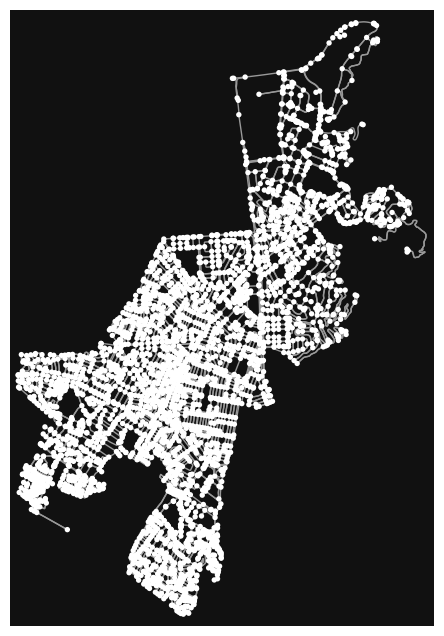

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [51]:
import googlemaps
import osmnx as ox
import networkx as nx
from datetime import datetime

# Get the real-time traffic data from Google Maps
def get_traffic_data(origin, destination):
    now = datetime.now()
    directions = gmaps.directions(
        origin, 
        destination, 
        mode="driving", 
        departure_time=now, 
        traffic_model="best_guess"  # You can change to 'pessimistic' or 'optimistic'
    )
    return directions

# Function to assign traffic times to graph edges
def add_traffic_to_graph(G, origin, destination):
    traffic_data = get_traffic_data(origin, destination)
    
    # Example: Extracting the first leg of the route and assigning to the graph
    for leg in traffic_data[0]['legs'][0]['steps']:
        start_lat = leg['start_location']['lat']
        start_lng = leg['start_location']['lng']
        end_lat = leg['end_location']['lat']
        end_lng = leg['end_location']['lng']
        
        # Find the closest graph nodes to these coordinates
        start_node = ox.distance.nearest_nodes(G, start_lng, start_lat)
        end_node = ox.distance.nearest_nodes(G, end_lng, end_lat)
        
        # Get the duration with traffic if available, otherwise use regular duration
        if 'duration_in_traffic' in leg:
            duration_with_traffic = leg['duration_in_traffic']['value']  # in seconds
        else:
            print("Traffic data not available for this segment, using regular duration.")
            duration_with_traffic = leg['duration']['value']  # fallback to normal duration
        
        # Add or update the edge with the new weight (time in seconds)
        if G.has_edge(start_node, end_node):
            G[start_node][end_node][0]['time'] = duration_with_traffic
        elif G.has_edge(end_node, start_node):
            G[end_node][start_node][0]['time'] = duration_with_traffic

    return G

# Example usage
G = ox.graph_from_place('Santiago de Surco, Lima, Peru', network_type='drive')
origin = "UPC Monterrico, Lima, Peru"
destination = "Jockey Plaza, Lima, Peru"

G_with_traffic = add_traffic_to_graph(G, origin, destination)

# Visualize the graph with traffic times as edge weights
ox.plot_graph(G_with_traffic)


In [52]:
# List of origins and destinations
locations = [
    ("Larcomar, Miraflores, Lima, Peru", "Parque Kennedy, Miraflores, Lima, Peru"),
    ("Plaza San Martín, Lima, Peru", "Parque de la Exposición, Lima, Peru"),
    ("Jirón de la Unión, Lima, Peru", "Circuito Mágico del Agua, Lima, Peru"),
    ("Universidad de Lima, Lima, Peru", "Jockey Plaza, Lima, Peru"),
    ("Museo Larco, Pueblo Libre, Lima, Peru", "Plaza Mayor, Lima, Peru"),
    ("Real Plaza Salaverry, Lima, Peru", "Universidad del Pacífico, Lima, Peru"),
    ("Estadio Nacional, Lima, Peru", "Gran Teatro Nacional, Lima, Peru"),
    ("Parque de las Leyendas, Lima, Peru", "Plaza Norte, Lima, Peru"),
    ("Parque El Olivar, San Isidro, Lima, Peru", "El Polo, Santiago de Surco, Lima, Peru"),
    ("Plaza Vea Chacarilla, Lima, Peru", "Open Plaza Angamos, Lima, Peru")
]

# Iterate over each origin-destination pair
for origin, destination in locations:
    try:
        print(f"Testing route from {origin} to {destination}")
        G_with_traffic = add_traffic_to_graph(G, origin, destination)
        print(f"Traffic data added for route from {origin} to {destination}")
    except Exception as e:
        print(f"Error for route from {origin} to {destination}: {e}")


Testing route from Larcomar, Miraflores, Lima, Peru to Parque Kennedy, Miraflores, Lima, Peru
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data added for route from Larcomar, Miraflores, Lima, Peru to Parque Kennedy, Miraflores, Lima, Peru
Testing route from Plaza San Martín, Lima, Peru to Parque de la Exposición, Lima, Peru
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data added f

In [53]:
#%pip install mapbox

## USANDO MAPBOX

In [54]:
import osmnx as ox
import networkx as nx
from mapbox import Directions
from datetime import datetime

# Setup Mapbox API with your access token
mapbox_access_token = get_env_variable('API_KEY_MPBOX')
service = Directions(access_token=mapbox_access_token)

# Get traffic data from Mapbox
def get_traffic_data_mapbox(origin, destination):
    # Coordinates must be (longitude, latitude)
    origin_coords = (origin[1], origin[0])  # Convert to (lng, lat)
    destination_coords = (destination[1], destination[0])

    # Create features for the origin and destination
    features = [{
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': origin_coords
        }
    }, {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': destination_coords
        }
    }]

    # Make the request with the 'driving-traffic' profile
    response = service.directions(
        features=features,
        profile='mapbox/driving-traffic',
        overview='full',
        geometries='geojson',
    )
    
    # Parse the response
    if response.status_code == 200:
        data = response.json()
        return data['routes'][0]['legs'][0]['steps']
    else:
        raise Exception(f"Error fetching data from Mapbox: {response.status_code}")

# Function to assign traffic times to graph edges
def add_traffic_to_graph_mapbox(G, origin_coords, destination_coords):
    traffic_data = get_traffic_data_mapbox(origin_coords, destination_coords)
    
    # Extracting traffic data and assigning it to the graph edges
    for step in traffic_data:
        start_coords = step['geometry']['coordinates'][0]
        end_coords = step['geometry']['coordinates'][-1]

        # Find the closest graph nodes to these coordinates
        start_node = ox.distance.nearest_nodes(G, start_coords[0], start_coords[1])
        end_node = ox.distance.nearest_nodes(G, end_coords[0], end_coords[1])

        # Get the duration in seconds (traffic aware)
        duration_with_traffic = step['congestion']  # in seconds
        print(duration_with_traffic)
        # Add or update the edge with the new weight (time in seconds)
        if G.has_edge(start_node, end_node):
            G[start_node][end_node][0]['time'] = duration_with_traffic
        elif G.has_edge(end_node, start_node):
            G[end_node][start_node][0]['time'] = duration_with_traffic

    return G

# Example graph and test
G = ox.graph_from_place('Santiago de Surco, Lima, Peru', network_type='drive')

# Use latitude and longitude for origin and destination
origin_coords = (-12.107, -76.963)  # UPC Monterrico, Lima, Peru
destination_coords = (-12.089, -76.978)  # Jockey Plaza, Lima, Peru

G_with_traffic = add_traffic_to_graph_mapbox(G, origin_coords, destination_coords)



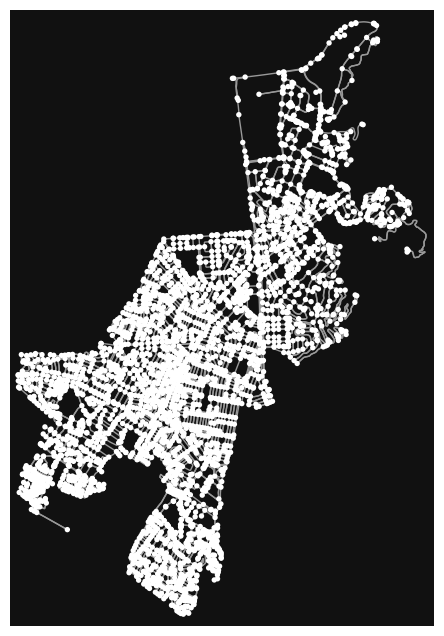

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [55]:
# Visualize the graph with traffic times as edge weights
ox.plot_graph(G_with_traffic)

In [56]:
import requests
import matplotlib.pyplot as plt

# Replace this with your own Mapbox access token
access_token = get_env_variable('API_KEY_MPBOX')


from geopy.geocoders import Nominatim

def get_coordinates(location):
    geolocator = Nominatim(user_agent="my_geocoder_app")
    location = geolocator.geocode(location)
    return (location.longitude, location.latitude)

def get_coordinates_from_address(address):
    # Geocoding URL for Mapbox
    geocode_url = f"https://api.mapbox.com/geocoding/v5/mapbox.places/{address}.json"
    
    # Parameters for geocoding request
    geocode_params = {
        "access_token": access_token,
        "limit": 1  # Return only the best match
    }

    # Send the geocoding request
    response = requests.get(geocode_url, params=geocode_params)
    if response.status_code == 200:
        data = response.json()
        if data['features']:
            # Extract the coordinates
            coordinates = data['features'][0]['geometry']['coordinates']
            return coordinates  # [longitude, latitude]
        else:
            raise ValueError("No matching location found.")
    else:
        raise Exception(f"Geocoding API error: {response.status_code}")

def get_directions_from_addresses(address1, address2):
    # Get coordinates for the first address
    coords1 = get_coordinates(address1)
    
    # Get coordinates for the second address
    coords2 = get_coordinates(address2)
    
    # Prepare the coordinates string for the directions API
    coordinates = f"{coords1[0]},{coords1[1]};{coords2[0]},{coords2[1]}"  # "longitude,latitude;longitude,latitude"
    
    # Directions API URL
    directions_url = f"https://api.mapbox.com/directions/v5/mapbox/driving-traffic/{coordinates}"
    
    # Parameters for the directions request
    directions_params = {
        "access_token": access_token,
        "alternatives": "false",
        #"steps": "true",
        "geometries": "geojson",
        "overview": "full",
        "annotations": "congestion"  # Updated to use supported annotations
    }

    # Send the directions request
    response = requests.get(directions_url, params=directions_params)
    if response.status_code == 200:
        directions = response.json()
        return directions
    else:
        raise Exception(f"Directions API error: {response.status_code}")

# Example Usage:
address1 = "UPC Monterrico, Lima, Peru"
address2 = "Jockey Plaza, Lima, Peru"

directions = get_directions_from_addresses(address1, address2)

# Print the directions result (as JSON or further processed)
print(directions)


{'routes': [{'weight_typical': 2065.888, 'duration_typical': 741.21, 'weight_name': 'auto', 'weight': 2184.924, 'duration': 843.446, 'distance': 4946.543, 'legs': [{'via_waypoints': [], 'admins': [{'iso_3166_1_alpha3': 'PER', 'iso_3166_1': 'PE'}], 'annotation': {'congestion': ['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'unknown', 'low', 'low', 'low', 'unknown', 'low', 'low', 'low', 'low', 'unknown', 'unknown', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'unknown', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'unknown', 'unknown', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'lo

In [57]:
def handle_unknown_congestion(congestion_data):
    # Reemplazar 'unknown' con un valor predeterminado, como 'low'
    return ['low' if level == 'unknown' else level for level in congestion_data]

# En el lugar donde procesas la respuesta:
if 'congestion' in directions['routes'][0]['legs'][0]['annotation']:
    congestion_levels = directions['routes'][0]['legs'][0]['annotation']['congestion']
    congestion_levels = handle_unknown_congestion(congestion_levels)

print(len(congestion_levels), congestion_levels[0])
print(list(set(congestion_levels)))


198 low
['low']


In [58]:
# Extract route coordinates
coordinates = []
if 'routes' in directions and directions['routes']:
    route = directions['routes'][0]  # Assuming the first route
    geometry = route['geometry']
    if 'coordinates' in geometry:
        route_coordinates = geometry['coordinates']
        #print("Route Coordinates:")
        for coord in route_coordinates:
            coordinates.append((coord[0],coord[1]))
            #print(f"  - {coord[0]}, {coord[1]} (longitude, latitude)")  # Access longitude and latitude
    else:
        print("No route coordinates found in the response.")
else:
    print("Error: No routes found in the directions response.")

print(len(coordinates), coordinates[0])
print(coordinates)

199 (-76.962965, -12.103788)
[(-76.962965, -12.103788), (-76.962481, -12.103428), (-76.962459, -12.103417), (-76.962443, -12.103418), (-76.962433, -12.103428), (-76.962424, -12.103445), (-76.962374, -12.103578), (-76.962354, -12.103601), (-76.962302, -12.103627), (-76.962317, -12.103581), (-76.962361, -12.103473), (-76.962479, -12.10322), (-76.96249, -12.103197), (-76.962529, -12.103117), (-76.962581, -12.103043), (-76.962634, -12.102967), (-76.96274, -12.102836), (-76.962829, -12.102746), (-76.962882, -12.102693), (-76.962911, -12.102672), (-76.962945, -12.102652), (-76.962978, -12.10264), (-76.963015, -12.102626), (-76.96304, -12.102617), (-76.963263, -12.102539), (-76.963547, -12.102423), (-76.963599, -12.102401), (-76.963772, -12.10232), (-76.96394, -12.102214), (-76.96402, -12.102157), (-76.964093, -12.102096), (-76.964101, -12.102089), (-76.964204, -12.101984), (-76.964432, -12.101745), (-76.964562, -12.101586), (-76.964686, -12.101381), (-76.964754, -12.10126), (-76.96481, -12.1

Coordenadas de UPC: (-76.96297465875287, -12.104031549999998)
Coordenadas de Jockey Plaza: (-76.9753818, -12.0862037)
419866837 4054805276 6129287592 6129287592
[419866837, 4054805276, 393864453, 3787830258, 392154421, 392154420, 10705500867, 392154413, 4054952827, 10705500870, 4353146639, 4054952829, 4054952830, 4054952831, 4054952832, 4352787709, 392154435, 392154445, 392154441, 4352900896, 392154440, 392154438, 4366751214, 393867109, 4353165250, 419484652, 4366990650, 393867114, 419484719, 393867117, 6129287596, 6129287592]


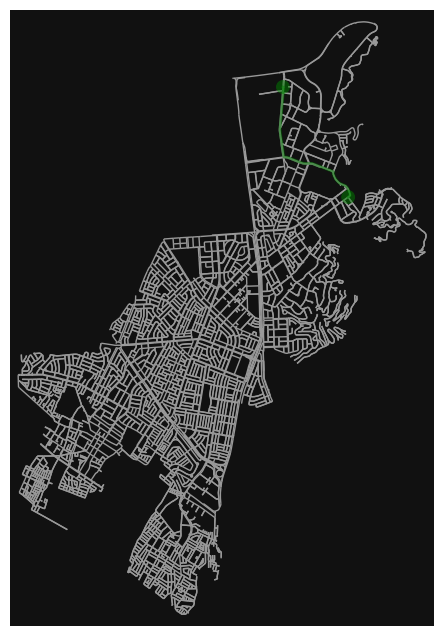

Distancia desde la UPC Monterrico al Jockey Plaza: 2.86 km


In [59]:

# Ejemplo de uso
upc_coords = get_coordinates("UPC Monterrico, Lima, Peru")
jockey_coords = get_coordinates("Jockey Plaza, Lima, Peru")

print("Coordenadas de UPC:", upc_coords)
print("Coordenadas de Jockey Plaza:", jockey_coords)

# Descargar el grafo de la red vial en torno a la UPC y el Jockey Plaza
G = ox.graph_from_place('Santiago de Surco, Lima, Peru', network_type='drive')


# Obtener los nodos más cercanos a las ubicaciones de interés
upc_node = ox.distance.nearest_nodes(G, upc_coords[0], upc_coords[1])
jockey_node = ox.distance.nearest_nodes(G, jockey_coords[0], jockey_coords[1])

n = len(coordinates) 
upc_node2 = ox.distance.nearest_nodes(G, coordinates[0][0], coordinates[0][1]) + 8
jockey_node2 = ox.distance.nearest_nodes(G, coordinates[n-1][0], coordinates[n-1][1])


# Calcular la ruta más corta en términos de distancia
shortest_route = nx.shortest_path(G, upc_node, jockey_node, weight='length')

print(upc_node, upc_node2, jockey_node, jockey_node2)
print (shortest_route)


# Aproximar los nodos más cercanos a las coordenadas en tu grafo de Lima
nodes = [ox.distance.nearest_nodes(G, coord[0], coord[1]) for coord in coordinates]
#print(nodes)
# Obtener los valores únicos manteniendo el orden
unique_nodes = list(dict.fromkeys(nodes))


# Visualizar la ruta y los nodos
fig, ax = ox.plot_graph_route(G, shortest_route, route_linewidth=2, node_size=0, show=True, close=False, route_color='green')

# Añadir el nodo de la UPC con un color diferente
ax.scatter(G.nodes[upc_node]['x'], G.nodes[upc_node]['y'], c='red', s=100, label='UPC')

# Añadir el nodo del Jockey Plaza con un color diferente
ax.scatter(G.nodes[jockey_node]['x'], G.nodes[jockey_node]['y'], c='blue', s=100, label='Jockey Plaza')

# Añadir la leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

# Calcular la distancia total de la ruta
route_length = nx.shortest_path_length(G, upc_node, jockey_node, weight='length')
print(f"Distancia desde la UPC Monterrico al Jockey Plaza: {route_length/1000:.2f} km")

In [60]:
# Aproximar los nodos más cercanos a las coordenadas en tu grafo de Lima
nodes = [ox.distance.nearest_nodes(G, coord[0], coord[1]) for coord in coordinates]
#print(nodes)
## Obtener los valores únicos manteniendo el orden
#unique_nodes = list(dict.fromkeys(nodes))
#
## Mostrar los valores únicos
#print(unique_nodes)
print (shortest_route)
print(len(nodes))


[419866837, 4054805276, 393864453, 3787830258, 392154421, 392154420, 10705500867, 392154413, 4054952827, 10705500870, 4353146639, 4054952829, 4054952830, 4054952831, 4054952832, 4352787709, 392154435, 392154445, 392154441, 4352900896, 392154440, 392154438, 4366751214, 393867109, 4353165250, 419484652, 4366990650, 393867114, 419484719, 393867117, 6129287596, 6129287592]
199


In [61]:
# Imprimir posiciones de los nodos para verificar que todos tienen 'x' y 'y'
for node in nodes:
    if 'x' in G.nodes[node] and 'y' in G.nodes[node]:
        print(f"Nodo {node}: ({G.nodes[node]['x']}, {G.nodes[node]['y']})")
    else:
        print(f"Nodo {node} no tiene coordenadas.")


Nodo 4054805268: (-76.9628072, -12.1032225)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 393864453: (-76.9626337, -12.102967)
Nodo 393864453: (-76.9626337, -12.102967)
Nodo 3787830258: (-76.9628289, -12.1027457)
Nodo 3787830258: (-76.9628289, -12.1027457)
Nodo 3787830258: (-76.9628289, -12.1027457)
Nodo 3787830258: (-76.9628289, -12.1027457)
Nodo 3787830258: (-76.9628289, -12.1027457)
Nodo 3787830259: (-76.9629925, -12.1027997)
Nodo 3787830259: (-76.9629925, -12.1

In [62]:
# Definir el mapeo de los niveles de congestión a colores
congestion_colors = {
    'low': 'green',
    'moderate': 'yellow',
    'high': 'red',
    'severe': 'purple'
}


In [74]:
import networkx as nx
import matplotlib.pyplot as plt

# Diccionario para mapear niveles de congestión a colores hexadecimales
congestion_colors = {
    'low': '#00FF00',        # Verde (green)
    'moderate': '#FFFF00',   # Amarillo (yellow)
    'high': '#FF0000',       # Rojo (red)
    'severe': '#800080'      # Púrpura (purple)
}


# Crear un nuevo diccionario con los niveles de congestión para cada arista (nodo a nodo)
traffic_data = {}

unique_edges = set()
edge_colors = []

pos_unique = set()
pos = {}

for i in range(len(nodes) - 1):
    u, v = nodes[i], nodes[i + 1]  # Obtener los nodos consecutivos
    traffic_data[(u, v)] = congestion_levels[i]  # Asignar nivel de congestión
    
    # if  u!=v and (u,v) not in unique_edges:
    #     #print((u,v), congestion_levels[i])
    #     #print(u)
    #     unique_edges.add((u,v))
    #     if u not in pos_unique:
    #         pos[u] = (G.nodes[u]['x'], G.nodes[u]['y'])
    #         pos_unique.add(u)

# Crear listas de colores y grosores para las aristas
edge_colors = []
edge_widths = []

for edge in G.edges:
    if edge in traffic_data:  # Si hay nivel de congestión para esta arista
        congestion_level = traffic_data[edge]
        edge_colors.append(congestion_colors.get(congestion_level, '#800080'))  # Asignar color
        edge_widths.append(5)  # Aumentar grosor para rutas con tráfico
    else:
        edge_colors.append('#f0f0f0')  # Aristas sin congestión en gris
        edge_widths.append(1)  # Mantener grosor fino para las que no tienen información

# Generar las posiciones de los nodos con coordenadas
pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes}


# Crear una lista de colores para los nodos basada en la congestión
node_colors = []
for node in G.nodes():
    congestion_level = None
    for (u, v), level in traffic_data.items():
        if u == node or v == node:
            congestion_level = level
            break
    if congestion_level is not None:
        node_colors.append(congestion_colors[congestion_level])
    else:
        node_colors.append('#A9A9A9')  # Color gris para nodos sin congestión


plt.figure(figsize=(12, 12))  # Ajusta el tamaño de la figura aquí

# Dibujar los nodos
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1)

# Dibujar las aristas (puedes ajustar el color de las aristas si es necesario)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors,  alpha=1)

# Mostrar el grafo
plt.title('Grafo de Tráfico en Lima')
plt.axis('off')  # Ocultar el eje
plt.show()
